In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

#Librerias para graficar
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/202120_Laboratorio_2_datos_BancAlpes_credit_card_data.csv",sep=";", index_col="Id", na_values=["?","-"])
data

,Customer,Limit_bal,Sex,Education,Marriage,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Id,,,,,,,,,,
1,87073.0,20000.0,Female,2,Married,24.0,2.0,1.0,1.0,0.0
2,38414.0,120000.0,Female,2,Single,26.0,3.0,0.0,10.0,9.0
3,17341.0,90000.0,Female,2,Single,34.0,7.0,1.0,3.0,4.0
4,40496.0,50000.0,Female,2,Married,37.0,5.0,1.0,1.0,NaN
5,47437.0,50000.0,Male,2,Married,57.0,6.0,0.0,12.0,3.0
...,...,...,...,...,...,...,...,...,...,...
656,51108.0,280000.0,Male,2,Married,39.0,10.0,1.0,10.0,0.0
657,60732.0,290000.0,Female,3,Single,27.0,10.0,1.0,13.0,2.0
658,53834.0,190000.0,Female,1,Single,28.0,8.0,1.0,9.0,1.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 1 to 660
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer             658 non-null    float64
 1   Limit_bal            659 non-null    float64
 2   Sex                  659 non-null    object 
 3   Education            659 non-null    object 
 4   Marriage             657 non-null    object 
 5   Age                  659 non-null    float64
 6   Total_Credit_Cards   658 non-null    float64
 7   Total_visits_bank    656 non-null    float64
 8   Total_visits_online  659 non-null    float64
 9   Total_calls_made     658 non-null    float64
dtypes: float64(7), object(3)
memory usage: 56.7+ KB


### Exploración de columnas

#### Transformación de columnas cualitativas

Data antes del procesamiento
 Female    372
Male      273
M           3
Mael        3
F           3
f           2
9           1
Fmale       1
Femael      1
Name: Sex, dtype: int64
Data después del procesamiento



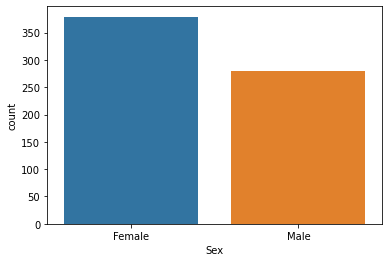

In [4]:
print("Data antes del procesamiento\n",data["Sex"].value_counts())
data["Sex"] = data["Sex"].replace("M","Male")
data["Sex"] = data["Sex"].replace("M ","Male")
data["Sex"] = data["Sex"].replace("Mael","Male")
data["Sex"] = data["Sex"].replace("F","Female")
data["Sex"] = data["Sex"].replace("f","Female")
data["Sex"] = data["Sex"].replace("Fmale","Female")
data["Sex"] = data["Sex"].replace("Femael","Female")
data["Sex"] = data["Sex"].replace("9",np.nan)
print("Data después del procesamiento\n")
ax = sns.countplot(x="Sex", data=data)

Data antes del procesamiento
 2      288
1      264
3       99
5        3
4        2
6        2
ABC      1
Name: Education, dtype: int64
Data después del procesamiento



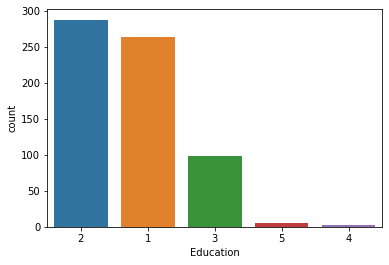

In [5]:
print("Data antes del procesamiento\n",data["Education"].value_counts())
data["Education"] = data["Education"].replace("ABC",np.nan)
data["Education"] = data["Education"].replace("6","5")
print("Data después del procesamiento\n")
ax = sns.countplot(x="Education", data=data)

Data antes del procesamiento
 Single     379
Married    260
Others       9
1            5
2            3
0            1
Name: Marriage, dtype: int64
Data después del procesamiento



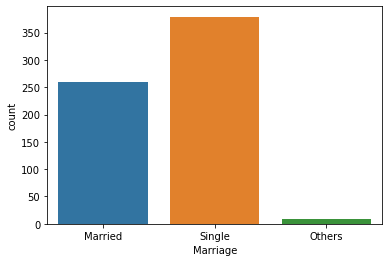

In [6]:
print("Data antes del procesamiento\n",data["Marriage"].value_counts())
data["Marriage"] = data["Marriage"].replace("1",np.nan)
data["Marriage"] = data["Marriage"].replace("2",np.nan)
data["Marriage"] = data["Marriage"].replace("0",np.nan)
print("Data después del procesamiento\n")
ax = sns.countplot(x="Marriage", data=data)

#### Transformación columnas cuantitativas

In [7]:
data_numeric=data[["Customer","Limit_bal","Age","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]]
data_numeric.describe()

,Customer,Limit_bal,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,658.000000,659.000000,659.000000,6.580000e+02,656.00000,659.000000,658.000000
mean,55180.056231,170000.000000,95.218513,1.876290e+05,2.41311,2.602428,3.579027
std,25651.348197,129739.041329,1432.660847,4.812847e+06,1.63130,2.936469,2.868076
min,11265.000000,10000.000000,21.000000,1.000000e+00,0.00000,0.000000,0.000000
25%,33875.500000,50000.000000,28.000000,3.000000e+00,1.00000,1.000000,1.000000
50%,53907.000000,140000.000000,33.000000,5.000000e+00,2.00000,2.000000,3.000000
75%,77321.500000,240000.000000,41.000000,6.000000e+00,4.00000,4.000000,5.000000
max,99843.000000,630000.000000,36745.000000,1.234568e+08,5.00000,15.000000,10.000000


SE ouede observar que el máximo de la edad es muy alto teniendo en cuenta la realidad y por lo tanto hay outliers. Se puede observar que el máximo de Total_credi_Cards es muy alto respecto al 75% por lo tanto hay outliers

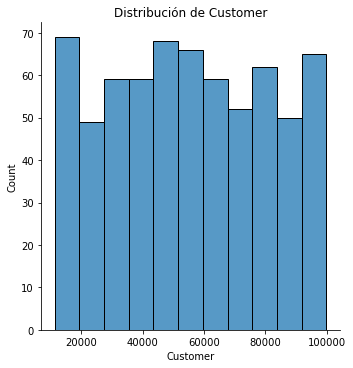

In [16]:
sns.displot(data["Customer"]).set(title="Distribución de Customer");

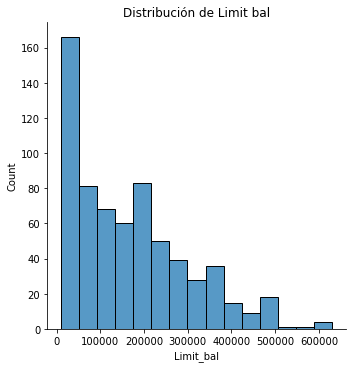

In [15]:
sns.displot(data["Limit_bal"]).set(title="Distribución de Limit bal");

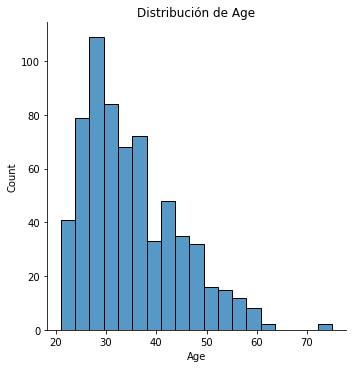

In [19]:
data= data[data["Age"] < max(data["Age"])] #Aqui se quietaron los 3 valores más altos
sns.displot(data["Age"]).set(title="Distribución de Age");

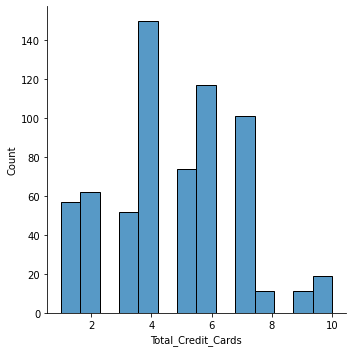

In [20]:
data= data[data["Total_Credit_Cards"] < max(data["Total_Credit_Cards"])] #Aqui se quietaron los 1 valores más altos
sns.displot(data["Total_Credit_Cards"]);

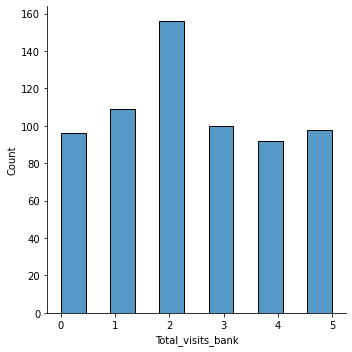

In [21]:
sns.displot(data["Total_visits_bank"]);

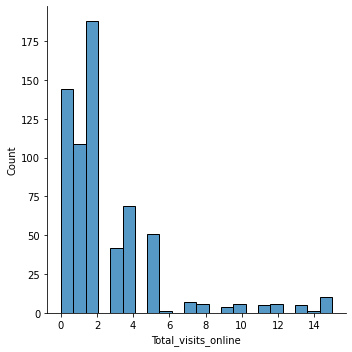

In [22]:
sns.displot(data["Total_visits_online"]);

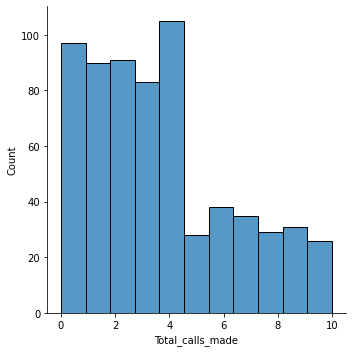

In [23]:
sns.displot(data["Total_calls_made"]);

#### Descripción de columnas numericas

In [24]:
data_numeric=data[["Customer","Limit_bal","Age","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]]
data_numeric.describe()

,Customer,Limit_bal,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,653.000000,654.000000,654.000000,654.000000,651.000000,654.000000,653.000000
mean,55117.849923,170137.614679,35.064220,4.729358,2.425499,2.594801,3.560490
std,25659.817546,129589.336139,9.363454,2.161580,1.629128,2.944516,2.865294
min,11265.000000,10000.000000,21.000000,1.000000,0.000000,0.000000,0.000000
25%,33837.000000,52500.000000,28.000000,3.000000,1.000000,1.000000,1.000000
50%,53916.000000,140000.000000,33.000000,5.000000,2.000000,2.000000,3.000000
75%,77143.000000,240000.000000,41.000000,6.000000,4.000000,4.000000,5.000000
max,99843.000000,630000.000000,75.000000,10.000000,5.000000,15.000000,10.000000


En este puonto las variables numericas percen ser normales

In [27]:
sns.boxplot(data=data_numeric[]["Customer","Age","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"], orient="h", palette="Set2");

SyntaxError: invalid syntax (<ipython-input-27-1b5f876f14c5>, line 1)

In [ ]:
sns.pairplot(data=data_numeric);

### Encoding

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
